This notebook combines text data for every reddit account and classifies them with two sklearn classifiers

In [112]:
import praw
import pandas as pd
import datetime
import numpy as np
import nltk
import sklearn
import sklearn.naive_bayes
import sklearn.neural_network
import sklearn.decomposition

import matplotlib.pyplot as plt #Plots
from matplotlib.colors import ListedColormap
import seaborn #Makes plots look nice, also heatmaps
secret = '****************'
clientID =  '***********'
username = "*********"
password = "*********"

In [113]:
reddit = praw.Reddit(client_id= clientID,
                     client_secret= secret,
                     user_agent= '/u/' + username,
                     username= username,
                     password= password)
#convert the instance to read only mode by:
reddit.read_only = True

In [114]:
data = pd.read_excel('C:\\Users\\Andrew\\Documents\\jupyter studies\\reddit\\moderatorList.xlsx')
data.moderator = data.moderator.apply(lambda x: x.split()[0])

In [115]:
data = pd.read_pickle('C:\\Users\\Andrew\\Documents\\jupyter studies\\reddit\\AllAccounts.pkl')

In [116]:
data['nym']=data.user.apply(lambda x: x.name)

In [117]:
nome = []
heck = []
for index, row in data.iterrows():
    if row.nym not in nome:
        if row.hack==1:
            nome.append(row.nym)
            heck.append(row.hack)

In [118]:
 simple =data.groupby('nym')['text'].apply(lambda x: x.sum())

In [119]:
simple =simple.add_suffix('_Count').reset_index()

In [120]:
simple['hack']=0
for index, row in simple.iterrows():
    if row.nym.endswith('_Count'):
        simple.loc[index,'nym'] = row.nym[:-6]

    if row.nym[:-6] in nome:
        simple.loc[index,'hack']= 1

   
len(simple[simple.hack==0])

191

In [121]:
len(simple[simple.hack==1])

326

In [122]:
#simple.drop(simple.tail(0).index,inplace=True)
#simple.tail()

,nym,text,hack
512,wadeharriot,Looks like Trump isn't doing quite wellRussia'...,1
513,walterwhite1962,Perfect ass,1
514,wannabelikeme,Sevgi Fernandez: Our voices are more powerful ...,0
515,xameg,Heroes of the Storm EU 2 keys giveawayI'll jus...,1
516,zettapede,Hillary Clinton releases new attack ad on Dona...,0


In [124]:
stop_words_basic = nltk.corpus.stopwords.words('english')
stemmer_basic = nltk.stem.snowball.SnowballStemmer('english')
lemmer_basic = nltk.stem.WordNetLemmatizer()

def normalizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)

    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)

    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

def generateVecs(df):
    df['tokenized_text'] = df['text'].apply(lambda x: nltk.word_tokenize(x))
    df['normalized_text'] = df['tokenized_text'].apply(lambda x: normalizeTokens(x, stopwordLst = stop_words_basic, stemmer = stemmer_basic))
    redditCountVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
    redditVects = redditCountVectorizer.fit_transform([' '.join(l) for l in df['normalized_text']])
    df['vect'] = [np.array(v).flatten() for v in redditVects.todense()]
    return df
def evaluateClassifier(clf, testDF):
    predictions = clf.predict(np.stack(testDF['vect'], axis=0))
    classes = []
    results = {
        'Error_Rate' : [],
        'AUC' : [],
        'Precision' : [],
        'Average_Precision' : [],
        'Recall' : [],
        }

    for cat in set(testDF['hack']):
        preds = [True if (c == cat) else False for c in predictions]
        acts = [True if (c == cat) else False for c in testDF['hack']]
        classes.append(cat)
        results['AUC'].append(sklearn.metrics.roc_auc_score(acts, preds))
        results['Average_Precision'].append(sklearn.metrics.average_precision_score(acts, preds))
        results['Precision'].append(sklearn.metrics.precision_score(acts, preds))
        results['Recall'].append(sklearn.metrics.recall_score(acts, preds))
        results['Error_Rate'].append(1 -  sklearn.metrics.accuracy_score(acts, preds))
    df = pd.DataFrame(results, index=classes)
    df.index.rename('hack', inplace=True)
    return df

def plotConfusionMatrix(clf, testDF):
    predictions = clf.predict(np.stack(testDF['vect'], axis=0))
    mat = sklearn.metrics.confusion_matrix(predictions, testDF['hack'])
    seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                    xticklabels=testDF['hack'].unique(), yticklabels=testDF['hack'].unique())
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.title("Confusion Matrix")
    plt.show()
    plt.close()
    
def plotMultiROC(clf, testDF):
    #By making the column names variables we can easily use this function on new data sets

    #Get the names of each of the possible classes and the probabiltiess
    classes = clf.classes_
    try:
        probs = clf.predict_proba(np.stack(testDF['vect'], axis=0))
    except AttributeError:
        print("The {} classifier does not apear to support prediction probabilties, so an ROC curve can't be created. You can try adding `probability = True` to the model specification or use a different model.".format(type(clf)))
        return
    predictions = clf.predict(np.stack(testDF['vect'], axis=0))

    #setup axis for plotting
    fig, ax = plt.subplots(figsize = (10,10))

    #We can return the AUC values, in case they are useful
    aucVals = []
    for classIndex, className in enumerate(classes):        #Setup binary classes
        truths = [1 if c == className else 0 for c in testDF['hack']]
        predict = [1 if c == className else 0 for c in predictions]
        scores = probs[:, classIndex]

        #Get the ROC curve
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(truths, scores)
        auc = sklearn.metrics.auc(fpr, tpr)
        aucVals.append(auc)

        #Plot the class's line
        ax.plot(fpr, tpr, label = "{} (AUC ${:.3f}$)".format(str(className).split(':')[0], auc))

    #Make the plot nice, then display it
    ax.set_title('Receiver Operating Characteristics')
    plt.plot([0,1], [0,1], color = 'k', linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc = 'lower right')
    plt.show()
    plt.close()
    #return aucVals

def plotregions(clf, df, h = .01):
    if np.random.choice(df['vect']).shape[0] > 2:
        pca = sklearn.decomposition.PCA(n_components = 2)
        reduced_data = pca.fit_transform(np.stack(df['vect'], axis=0))
        transformedDF = pd.DataFrame({'vect' : [r for r in reduced_data], 'hack' : df['hack']})
    else:
        transformedDF = df
    catsMap = {c : i for i, c in enumerate(np.unique(df['hack']))}

    fig, ax = plt.subplots(figsize = (10,10))
    ax.axis('off')
    pallet = seaborn.color_palette(palette='coolwarm', n_colors = len(set(transformedDF['hack'])))

    if np.random.choice(df['vect']).shape[0] > 2:
        xx, yy = np.meshgrid(np.arange(1.1 * reduced_data[:,0].min(),
                1.1 * reduced_data[:,0].max(), h),
            np.arange(1.1 * reduced_data[:,1].min(),
                1.1 * reduced_data[:,1].max(), h))
        Z = clf.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    else:
        reduced_data = np.stack(df['vect'], axis=0)
        xx, yy = np.meshgrid(np.arange(1.1 * reduced_data[:,0].min(),
                1.1 * reduced_data[:,0].max(), h),
            np.arange(1.1 * reduced_data[:,1].min(),
                1.1 * reduced_data[:,1].max(), h))

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.vectorize(lambda x: catsMap[x])(Z)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
    for i, cat in enumerate(set(df['hack'])):
        a = np.stack(transformedDF[transformedDF['hack'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    plt.show()
    plt.close()

In [125]:
# for index, row in simple.iterrows():
#     if type(row.text) is not str:
#         print(row.text)
#         print(index)
simpl = generateVecs(simple)

In [126]:
simpl.head()

,nym,text,hack,tokenized_text,normalized_text,vect
0,1488reasons,We don't vote in American elections. Americans...,1,"[We, do, n't, vote, in, American, elections, ....","[vote, american, elect, american, care, think,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,316nuts,Why the 'Session' Beer Trend Makes Zero Sensew...,0,"[Why, the, 'Session, ', Beer, Trend, Makes, Ze...","[whi, beer, trend, make, zero, senseway, pick,...","[0.0, 0.0, 0.0, 0.019383522617274652, 0.0, 0.0..."
2,AdamSC1,Police chases white/black guyHow i see arabs b...,0,"[Police, chases, white/black, guyHow, i, see, ...","[polic, chase, guyhow, see, arab, polic, reall...","[0.03618679565065152, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,AddictedReddit,"Yes, Islam is not a race, you are still a raci...",0,"[Yes, ,, Islam, is, not, a, race, ,, you, are,...","[yes, islam, race, still, racistava, duvernay,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,AdoraronDoomworker,"Failed robberyKjeragBolten, stone located betw...",1,"[Failed, robberyKjeragBolten, ,, stone, locate...","[fail, robberykjeragbolten, stone, locat, two,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [127]:
count=0
for index, row in simpl.iterrows():

     if len(row.normalized_text)<1 and row.hack==1:
        count=count+1
#         print(index)
#         print(row.text)
print(count)

2


In [128]:
simpl.to_pickle('C:\\Users\\Andrew\\Documents\\jupyter studies\\reddit\\accountTexts.pkl')

In [131]:
print(len(simpl))
msk=np.random.rand(len(simpl)) < 0.8
train = simpl[msk]
test = simpl[~msk]

517


In [132]:
len(train)

412

In [133]:
len(train[train.hack==0])

153

In [134]:
len(train[train.hack==1])

259

In [135]:
len(test[test.hack==0])

38

In [136]:
len(test[test.hack==1])

67

In [137]:
len(test)

105

In [138]:
#train.to_pickle('C:\\Users\\Andrew\\Documents\\jupyter studies\\reddit\\strain.pkl')

In [139]:
#test.to_pickle('C:\\Users\\Andrew\\Documents\\jupyter studies\\reddit\\stest.pkl')

In [1]:
#naive bayes classifier:

In [140]:
naive = sklearn.naive_bayes.GaussianNB()

In [141]:
naive.fit(np.stack(train['vect'], axis=0), train['hack'])

GaussianNB(priors=None)

In [142]:
evaluateClassifier(naive, test)

,AUC,Average_Precision,Error_Rate,Precision,Recall
hack,,,,,
0,0.518068,0.370484,0.571429,0.372093,0.842105
1,0.518068,0.647043,0.571429,0.684211,0.194030


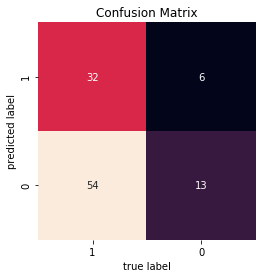

In [143]:
plotConfusionMatrix(naive, test)

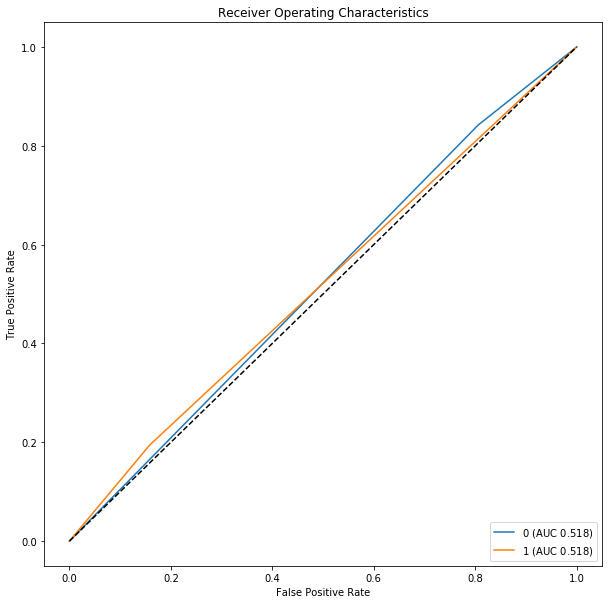

In [144]:
plotMultiROC(naive, test)

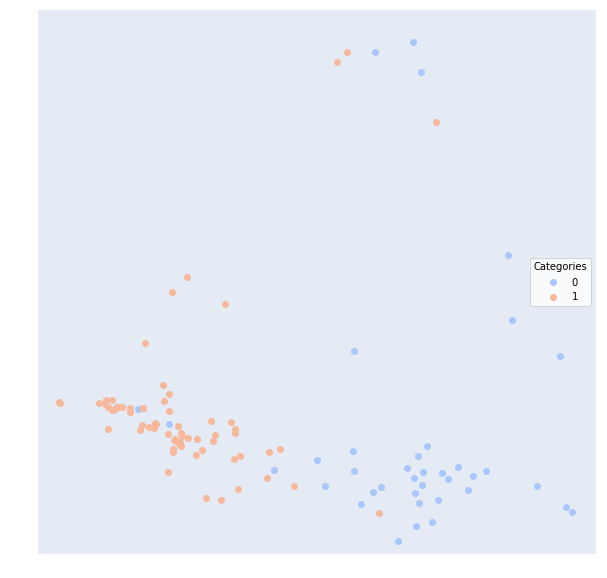

In [145]:
plotregions(naive, test)

sklearn neural network:

In [146]:
neuro = sklearn.neural_network.MLPClassifier()

In [147]:
neuro.fit(np.stack(train['vect'], axis=0), train['hack'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [148]:
evaluateClassifier(neuro, test)

,AUC,Average_Precision,Error_Rate,Precision,Recall
hack,,,,,
0,0.610369,0.429269,0.380952,0.478261,0.578947
1,0.610369,0.696317,0.380952,0.728814,0.641791


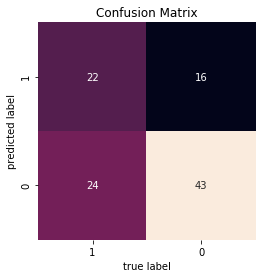

In [149]:
plotConfusionMatrix(neuro, test)

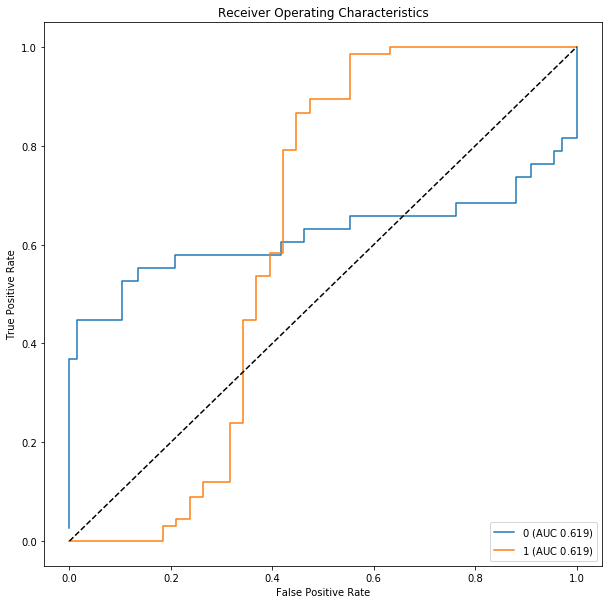

In [150]:
plotMultiROC(neuro, test)

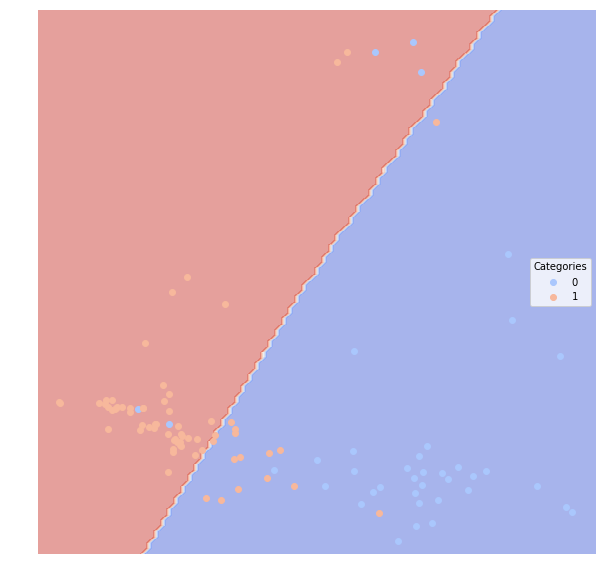

In [151]:
plotregions(neuro, test)